<ipython-input-1-f6c56d078cd7>:54: RuntimeWarning: invalid value encountered in double_scalars
  accept_pro = (likelihood_proposal*prior_proposal)/(likelihood_current_location*prior_current_location)
<ipython-input-1-f6c56d078cd7>:54: RuntimeWarning: divide by zero encountered in double_scalars
  accept_pro = (likelihood_proposal*prior_proposal)/(likelihood_current_location*prior_current_location)


[[  0.9693839  388.5375129 ]
 [  0.9693839  388.5375129 ]
 [  0.9693839  388.5375129 ]
 ...
 [  0.97378893 380.15638536]
 [  0.97378893 380.15638536]
 [  0.97378893 380.15638536]]
[311.20267943342463, 320.4873970856221, 360.8433916610111, 390.69445112815447, 394.91752157151535, 395.4376907760471, 395.3772271034051, 395.51507263535467, 395.4866571252848]
[350.0447491221133, 359.1341807054442, 399.7676994114248, 429.2570213076389, 433.7199112547259, 434.22141066828334, 434.1766139938238, 434.1607820481732, 434.1849619578828]
[388.78528748443387, 397.7966530309597, 438.753163227051, 467.64467994160685, 472.42155494895206, 472.6838324103406, 472.84994932028553, 472.89289187611934, 473.02145082951887]


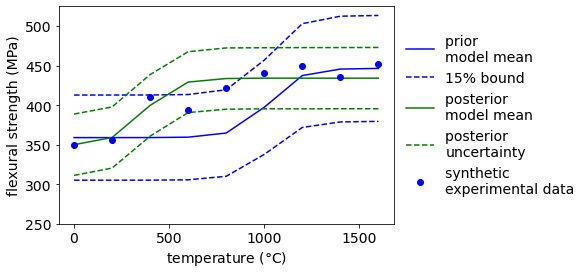

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})
from mpl_toolkits.mplot3d import Axes3D 
import scipy
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.integrate import odeint
import pandas as pd
import seaborn as sns
import pickle

#centered_synth_exp = [341.34307562, 343.39421741, 332.72204114, 370.54835985, 
#                      347.52350974, 400.16028132, 432.76704837, 417.17647725, 425.15201902]
#shifted_up_exp = [371.93923856, 422.0748083, 360.47125363, 407.79689099, 380.09236394,
#            417.76626157, 444.91269431, 459.29178947, 478.02731897]
#shifted_down_exp = [303.78800408, 317.47338596, 351.81246919, 333.06652442, 343.87121988, 
#                    393.48889663, 401.80579517, 424.7875635, 433.83970035]
#shifted_left_synth_exp = [349.95490152, 355.89666548, 410.05829427, 393.77353699, 421.84752866,
#                          441.0380559, 448.98198769, 435.41553941, 451.91814983]

class ip:
    # Q (for proposal samples).  
    # Initialize experimental data.
    mcmc_length = 250000
    mcmc_burn_in = 10000 # number of samples
    mu_prior = np.array([1.0, 1020.67])
    cov_prior = np.array([[1.0, 0.0],
                          [0.0, np.power(500.0,2)]])

    synth_exp = np.array([349.95490152, 355.89666548, 410.05829427, 393.77353699, 421.84752866,
                          441.0380559, 448.98198769, 435.41553941, 451.91814983])   
    Q_mu = np.array([0, 0])
    Q_cov = cov_prior
    #main function to get samples
    def MetropolisHastings(self):
        samples = np.zeros((self.mcmc_length,2)) 
        samples[0,:] = self.mu_prior #initialize the chain
        likelihoods_vec = np.zeros((self.mcmc_length,1))
        posteriors_un_normed_vec = np.zeros((self.mcmc_length,1))
        priors_vec = np.zeros((self.mcmc_length,1))
        for i in range(1,self.mcmc_length):
            proposal_sample = samples[i-1,:] + np.random.multivariate_normal(self.Q_mu,self.Q_cov)
            prior_proposal = self.prior(proposal_sample)
            likelihood_proposal = self.likelihood(proposal_sample)
            prior_current_location = self.prior(samples[i-1,:])
            likelihood_current_location = self.likelihood(samples[i-1,:])
            accept_pro = (likelihood_proposal*prior_proposal)/(likelihood_current_location*prior_current_location)
            uni_rand = np.random.uniform()
            if uni_rand<accept_pro:
                samples[i,:] = proposal_sample
                posteriors_un_normed_vec[i] = likelihood_proposal*prior_proposal
                likelihoods_vec[i] = likelihood_proposal
                priors_vec[i] = prior_proposal
            else:
                samples[i,:] = samples[i-1,:]
                posteriors_un_normed_vec[i] = likelihood_current_location*prior_current_location
                likelihoods_vec[i] = likelihood_current_location
                priors_vec[i] = prior_current_location
            ########################################
        samples = samples[self.mcmc_burn_in:]
        posteriors_un_normed_vec = posteriors_un_normed_vec[self.mcmc_burn_in:]
        likelihoods_vec = likelihoods_vec[self.mcmc_burn_in:]
        priors_vec = priors_vec[self.mcmc_burn_in:]
        #posterior probabilites are transformed to a standard normal (std=1)
        #for obtaining the evidence:
        evidence = np.mean(posteriors_un_normed_vec)*np.sqrt(2*np.pi*np.std(samples)**2)
        posteriors_vec = posteriors_un_normed_vec/evidence
        log_ratios = np.log(posteriors_vec/priors_vec)
        log_ratios[np.isinf(log_ratios)] = 0
        log_ratios = np.nan_to_num(log_ratios)
        info_gain = np.mean(log_ratios)
        return [evidence, info_gain, samples]
    
    def prior(self,sample):
        probability = multivariate_normal.pdf(x=sample, mean=self.mu_prior, cov=self.cov_prior, allow_singular=False)
        return probability
        
    def likelihood(self,sample): # The model goes in here
        T = np.linspace(0,1600,9)
        FS_array = (359+87.6/(1+np.exp(-0.012*(T-sample[1]))))*sample[0]
        SSE = np.sum(np.square(FS_array - self.synth_exp))/9
        #print(SSE)
        probability_ra = multivariate_normal.pdf(x=SSE,mean=0, cov=225)  
        #print(probability_ra)
        return probability_ra
#-------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------
 

evidences=[]
info_gains=[]
all_samples=[]

ip_object = ip()

[evidence, info_gain, samples] = ip_object.MetropolisHastings()
#evidences.append(evidence)
#info_gains.append(info_gain)
#all_samples.append(samples)
#print('Evidence: ' + str(evidence))
#print('Information Gain: ' + str(info_gain))
#print('Samples: ' +str(samples))
#print(samples.shape)  
#evidencearray = np.asarray(evidences)
#print('evidence shape')
#print(evidencearray.shape)

T = np.linspace(0,1600,9)

FS_upper_bound = []
FS_lower_bound = []
FS_mean = []
FS_temp = np.zeros((len(samples),1))
print(samples)
for temp in T:
    for i in range(len(samples)):
        #print(samples[i,1])
        FS_temp[i,0] = (359+87.6/(1+np.exp(-0.012*(temp-samples[i,1]))))*samples[i,0]
    #for i in FS_temp:
    #    FS_temp[i] = FS_temp[i] + 10*np.random.randn()
    #print(10*np.random.randn(len(FS_temp),1))
    FS_temp_total = FS_temp + 15*np.random.randn(len(FS_temp),1)
    #print(FS_temp)
    #print(FS_temp_total)
    FS_temp_total_sorted = np.sort(FS_temp_total, axis=0)
    #print(FS_temp_total.shape)
    #print(FS_temp_total_sorted)
    #print(int(np.round(0.05*len(FS_temp))))
    #print(int(np.round(0.95*len(FS_temp))))
    #print(int(np.round(0.5*len(FS_temp))))
    FS_lower_bound.append(FS_temp_total_sorted[int(np.round(0.005*len(FS_temp))),0])
    FS_upper_bound.append(FS_temp_total_sorted[int(np.round(0.995*len(FS_temp))),0])
    FS_mean.append(FS_temp_total_sorted[int(np.round(0.5*len(FS_temp))),0])
#print(samples)
print(FS_lower_bound)
print(FS_mean)
print(FS_upper_bound)

synth_exp = np.array([349.95490152, 355.89666548, 410.05829427, 393.77353699, 421.84752866,
                          441.0380559, 448.98198769, 435.41553941, 451.91814983])  

FS = 359+87.6/(1+np.exp(-0.012*(T-1020.67)))
FS_upper_15_percent = 1.15*359+1.15*87.6/(1+np.exp(-0.012*(T-1020.67)))
FS_lower_15_percent = 0.85*359+0.85*87.6/(1+np.exp(-0.012*(T-1020.67)))

plt.plot(T,FS,'b',label = 'prior \nmodel mean')
plt.plot(T,FS_upper_15_percent,'b--', label = '15% bound')
plt.plot(T,FS_lower_15_percent,'b--')
plt.plot(T,FS_mean,'g',label = 'posterior \nmodel mean')
plt.plot(T,FS_upper_bound,'g--', label = 'posterior \nuncertainty')
plt.plot(T,FS_lower_bound,'g--')
plt.plot(T,synth_exp,'bo',label = 'synthetic \nexperimental data') #standard deviation 20 MPa
plt.ylim([250,525])
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
#plt.legend(loc='upper left')
plt.ylabel(r'flexural strength (MPa)')
plt.xlabel(r'temperature ($\degree$C)')
plt.savefig('Bayes_flexural_strength_shifted_left.png',dpi=300,bbox_inches='tight')


bound =  [0.1106731  0.10765467 0.09752029 0.08942814 0.08923188 0.0885779
 0.08907282 0.08921144 0.08944688]
R squared posterior=  0.8219313079414869
R squared prior=  0.21147039797017964


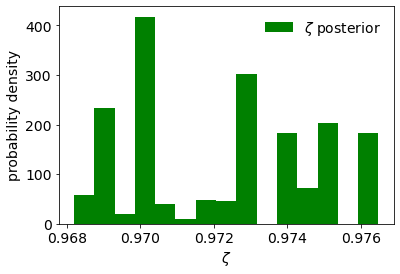

In [2]:
FS_upper_bound = np.array(FS_upper_bound)
FS_mean = np.array(FS_mean)
print("bound = ", (FS_upper_bound - FS_mean) / FS_mean)
SSE = np.sum(np.power(FS_mean - synth_exp,2))
TSS = np.sum(np.power(synth_exp - np.mean(synth_exp),2))
print("R squared posterior= ", 1 - SSE/TSS)
SSE_pri = np.sum(np.power(FS - synth_exp,2))
print("R squared prior= ", 1 - SSE_pri/TSS)
zeta_prior = 1 + np.random.randn(40000)
zeta_post = samples[:,0].flatten()
plt.hist(zeta_post,label=r'$\zeta$ posterior',color='g',bins=15,density=True)
plt.xlabel(r'$\zeta$')
plt.ylabel(r'probability density')
plt.legend(frameon=False)
plt.savefig('Bayes_zeta_param_shifted_left.png',dpi=300,bbox_inches='tight')


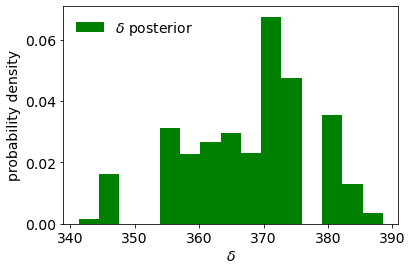

In [3]:
delta_post = samples[:,1].flatten()
plt.hist(delta_post,label=r'$\delta$ posterior',color='g',bins=15,density=True)
plt.xlabel(r'$\delta$')
plt.ylabel(r'probability density')
plt.legend(frameon=False)
plt.savefig('Bayes_delta_param_shifted_left.png',dpi=300,bbox_inches='tight')
